<a href="https://colab.research.google.com/github/COINtoolbox/Generalized-Linear-Models-Tutorial/blob/master/nb_pymc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# run_nb_eiv_mstar_pymc.py
# Bayesian Negative-Binomial regression for GC counts with Errors-in-Variables (PyMC)
# Predictor: x = log10(M*/Msun) derived from MV and (B-V) via Bell+03 (Chabrier IMF)
# Output: NGC_Mstar_pymc.pdf

import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as at
import arviz as az
import matplotlib.pyplot as plt

RNG_SEED = 42
np.random.seed(RNG_SEED)

In [ ]:
# ------------------------- Data ---------------------------------------------
url = "https://raw.githubusercontent.com/COINtoolbox/NB_GCs/refs/heads/master/Dataset/GCs_full.csv"
df = pd.read_csv(url, delim_whitespace=True)
df = df[df["MV_T"].notna()].copy()

/tmp/ipython-input-854762004.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url, delim_whitespace=True)


In [ ]:
# after reading and parsing the table (with delim_whitespace=True) and before df_fit:
df = df[df["Type"] == "E"].copy()


In [ ]:
print(df.columns.tolist())

['Galaxy', 'Type', 'N_GC', 'N_GC_err', 'Mdyn', 'MBH', 'sig_e', 'err_sig_e', 'A_V', 'MV_T', 'err_MV_T', 'MK', 'Re', 'upMBH', 'lowMBH', 'BV', 'sBV', 'MV0', 'logMstar_obs', 'err_logMstar']


In [ ]:
# Bell+03 (Chabrier) M*/L_V:
#   log10(M*/L_V) = -0.778 + 1.305 * (B-V)_0
#   M_V,0 = M_V - A_V ; M_V,Sun = 4.83
M_Vsun = 4.83

BV_typical = {"E":0.96, "S0":0.88, "S":0.70, "Irr":0.45}
BV_sigma   = {"E":0.05, "S0":0.06, "S":0.08, "Irr":0.10}

df["BV"]  = df["Type"].map(BV_typical)
df["sBV"] = df["Type"].map(BV_sigma)
df["MV0"] = df["MV_T"] - df["A_V"]

# Observed x = log10(M*/Msun)
df["logMstar_obs"] = -0.4*(df["MV0"] - M_Vsun) - 0.778 + 1.305*df["BV"]

# Propagate uncertainties (first-order):
# d logM*/d M_V = -0.4 ; d logM*/d(B-V) = 1.305
err_logMstar = np.sqrt((0.4*df["err_MV_T"])**2 + (1.305*df["sBV"])**2)
err_logMstar = err_logMstar.replace([np.inf, -np.inf], np.nan).fillna(0.01)
err_logMstar = np.maximum(err_logMstar, 0.01)
df["err_logMstar"] = err_logMstar

# Count uncertainties for measurement layer; floor at 0.5 (rounding)
df["N_GC_err"] = np.maximum(df["N_GC_err"], 0.5)

# Keep essentials and ensure integer counts
df_fit = (df
          .loc[np.isfinite(df["logMstar_obs"])
               & np.isfinite(df["err_logMstar"])
               & df["N_GC"].notna(),
               ["logMstar_obs", "err_logMstar", "N_GC", "N_GC_err"]]
          .copy())
df_fit["N_GC"] = np.maximum(0, np.round(df_fit["N_GC"]).astype(int))

x_obs    = df_fit["logMstar_obs"].to_numpy()
x_err    = df_fit["err_logMstar"].to_numpy()
N_GC     = df_fit["N_GC"].to_numpy().astype(float)  # Normal can take float observed
N_GC_err = df_fit["N_GC_err"].to_numpy()
N        = len(df_fit)

# Prediction grid
M      = 2000
x_pred = np.linspace(6.5, 12.5, M).astype(float)


In [ ]:
# ---------------- PyMC model (fast: no measurement error on N) ---------------
with pm.Model() as model_fast:
    # Priors
    beta0 = pm.Normal("beta0", 0.0, 10.0)
    beta1 = pm.Normal("beta1", 0.0, 10.0)
    phi   = pm.Gamma("phi", alpha=2.0, beta=0.1)         # NB2 dispersion
    alpha = pm.Deterministic("alpha", 1.0 / phi)         # PyMC: Var = mu + alpha*mu^2

    # EIV on predictor (per-datum x_err)
    x_true = pm.Normal("x_true", mu=x_obs, sigma=x_err, shape=N)

    # Mean relation
    eta = beta0 + beta1 * x_true
    mu  = pm.Deterministic("mu", at.exp(eta))

    # Direct NB likelihood on observed integer counts (no Normal layer)
    pm.NegativeBinomial("N_GC", mu=mu, alpha=alpha,
                        observed=df_fit["N_GC"].to_numpy(dtype=int))

    # Predictions on grid (deterministic; summarize posterior of mu_pred)
    mu_pred = pm.Deterministic("mu_pred", at.exp(beta0 + beta1 * x_pred))

    idata = pm.sample(
        draws=2000, tune=500, chains=3, cores=3,
        target_accept=0.9, random_seed=RNG_SEED
    )


Output()

In [ ]:
print(idata.posterior.data_vars)


Data variables:
    alpha    (chain, draw) float64 48kB 1.44 1.371 1.478 ... 1.506 1.382 1.425
    beta0    (chain, draw) float64 48kB -15.93 -16.35 -15.95 ... -15.93 -16.57
    beta1    (chain, draw) float64 48kB 2.118 2.153 2.106 ... 2.164 2.117 2.167
    mu       (chain, draw, mu_dim_0) float64 12MB 11.59 13.06 ... 5.129e+03
    mu_pred  (chain, draw, mu_pred_dim_0) float64 96MB 0.1149 ... 3.671e+04
    phi      (chain, draw) float64 48kB 0.6944 0.7294 0.6766 ... 0.7238 0.7018
    x_true   (chain, draw, x_true_dim_0) float64 12MB 8.678 8.735 ... 11.59


In [ ]:
# ------------------------- Summaries on mu_pred ------------------------------
# idata.posterior["mu_pred"] has shape (chain, draw, M)
# idata.posterior["mu_pred"] dims: (chain, draw, mu_pred_dim_0)
da = idata.posterior["mu_pred"]

q = da.quantile([0.05, 0.25, 0.50, 0.75, 0.95], dim=("chain", "draw"))  # -> (quantile, mu_pred_dim_0)

lwr95 = q.sel(quantile=0.05).values
lwr50 = q.sel(quantile=0.25).values
median = q.sel(quantile=0.50).values
upr50 = q.sel(quantile=0.75).values
upr95 = q.sel(quantile=0.95).values

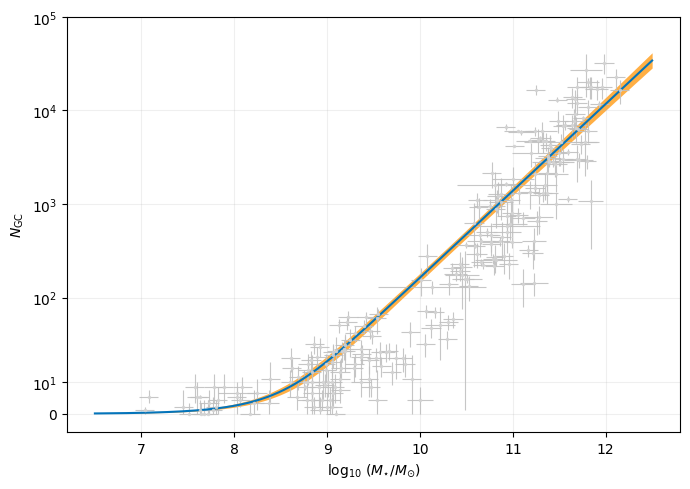

In [ ]:
# ------------------------- Plot (pseudo-log, base 10, sigma=5) --------------
def plog10_asinh(y, sigma=5.0):
    # y' = asinh( (y/sigma)/ln(10) )
    return np.arcsinh((y / sigma) / np.log(10.0))

# Ticks and labels to mimic your R plot
yticks = np.array([0, 10, 100, 1e3, 1e4, 1e5], dtype=float)
ytick_labels = ["0", r"$10^{1}$", r"$10^{2}$", r"$10^{3}$", r"$10^{4}$", r"$10^{5}$"]

fig, ax = plt.subplots(figsize=(7,5))

# data (transform y)
ax.errorbar(
    x_obs, plog10_asinh(N_GC),
    yerr=[plog10_asinh(N_GC) - plog10_asinh(np.maximum(N_GC - N_GC_err, 0.0)),
          plog10_asinh(N_GC + N_GC_err) - plog10_asinh(N_GC)],
    xerr=[x_err, x_err],
    fmt="o", ms=2.5, mfc="lightgray", mec="none", ecolor="silver", elinewidth=0.8, alpha=0.9
)

# ribbons + median (transform y)
ax.fill_between(
    x_pred, plog10_asinh(lwr95), plog10_asinh(upr95),
    alpha=0.9, color="#FFA630", linewidth=0
)
# Use a step-like feel: draw as a regular line; the grid is dense enough
ax.plot(x_pred, plog10_asinh(median), lw=1.5, color="#0474BA")

# y axis cosmetics
ax.set_yticks(plog10_asinh(yticks))
ax.set_yticklabels(ytick_labels)

ax.set_xlabel(r"$\log_{10}\,(M_{\star}/M_{\odot})$")
ax.set_ylabel(r"$N_{\rm GC}$")
ax.grid(True, alpha=0.2)
fig.tight_layout()
plt.show()